#### Import package

In [13]:
import os
import pytz
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import font_manager
import json
import math
from collections import Counter
from matplotlib import rcParams
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

#### Heterogenity analysis

In [2]:
proj_path= "/root/workspace/d23oa7cp420c73acue30/AgentOS/data"
dataset_heterogenity_dict= {
    "gaia": {
        "file": {"cpu": 1, "gpu": 3, "io": 0},
        "reason": {"cpu": 0, "gpu": 3, "io": 1},
        "speech": {"cpu": 1, "gpu": 4, "io": 0},
        "vision": {"cpu": 1, "gpu": 1, "io": 1},
    },
    "openagi": {
        "document_qa": {"cpu": 4, "gpu": 4, "io": 4},
        "image_captioning_complex": {"cpu": 3, "gpu": 6, "io": 2},
        "multimodal_vqa_complex": {"cpu": 2, "gpu": 4, "io": 3},
        "text_processing_multilingual": {"cpu": 2, "gpu": 6, "io": 4},
    },
    "tbench": {
        "airline_book": {"cpu": 5, "gpu": 2, "io": 0},
        "airline_cancel": {"cpu": 3, "gpu": 2, "io": 2},
        "retail_cancel": {"cpu": 1, "gpu": 2, "io": 2},
        "retail_cancel_modify": {"cpu": 3, "gpu": 1, "io": 2},
        "retail_modify": {"cpu": 3, "gpu": 1, "io": 2},
        "retail_return": {"cpu": 3, "gpu": 1, "io": 2}
    }
}

In [4]:
def calculate_shannon_entropy(task_counts: dict) -> float:
    """根据给定的任务总数字典，计算香农熵。"""
    counts = [count for count in task_counts.values() if count > 0]
    total_tasks = sum(counts)
    if total_tasks == 0 or len(counts) <= 1:
        return 0.0
    entropy = 0.0
    for count in counts:
        probability = count / total_tasks
        entropy -= probability * math.log2(probability)
    return entropy

In [5]:
def get_query_counts(jsonl_path: str, type_key: str = "dag_type") -> Counter:
    """读取 JSONL 文件并统计每种类型的查询数量。"""
    counts = Counter()
    try:
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    data = json.loads(line)
                    if type_key in data:
                        counts[data[type_key]] += 1
                except json.JSONDecodeError:
                    print(f"Warning: Skipping invalid JSON line in {jsonl_path}")
    except FileNotFoundError:
        print(f"Error: Query file not found at {jsonl_path}. Please check the path.")
        return None
    return counts

In [6]:
def analyze_dataset_workload(dataset_name: str, base_path: str, atomic_compositions: dict):
    """
    对数据集进行全面的工作负载分析，计算：
    1. 平均查询的资源构成百分比 (CPU %, GPU %, IO %)
    2. 整体数据集的异质性得分 (Entropy)
    """
    print(f"\n--- Analyzing Dataset: {dataset_name.upper()} ---")
    
    query_file_name = f"{dataset_name}_query.jsonl"
    query_file_path = os.path.join(base_path, dataset_name, query_file_name)
    json_type_key = "dag_type"

    # 步骤 1: 获取每种 query 的实际数量
    query_counts = get_query_counts(query_file_path, json_type_key)
    if not query_counts:
        print(f"Could not analyze {dataset_name} due to missing data.")
        return None
    total_queries = sum(query_counts.values())
    print(f"  - Found {total_queries} total queries. Counts: {dict(query_counts)}")

    # 步骤 2: 计算整个数据集中 cpu, gpu, io 的任务总数
    total_dataset_tasks = Counter()
    dataset_atomic_compositions = atomic_compositions.get(dataset_name, {})
    for query_type, count in query_counts.items():
        if query_type in dataset_atomic_compositions:
            atomic_comp = dataset_atomic_compositions[query_type]
            total_dataset_tasks['cpu'] += count * atomic_comp.get('cpu', 0)
            total_dataset_tasks['gpu'] += count * atomic_comp.get('gpu', 0)
            total_dataset_tasks['io'] += count * atomic_comp.get('io', 0)
    print(f"  - Total task composition across all queries: {dict(total_dataset_tasks)}")

    # 步骤 3: 计算平均每个查询的资源构成百分比
    total_tasks_sum = sum(total_dataset_tasks.values())
    composition_percentages = {}
    if total_tasks_sum > 0:
        composition_percentages['cpu'] = (total_dataset_tasks['cpu'] / total_tasks_sum) * 100
        composition_percentages['gpu'] = (total_dataset_tasks['gpu'] / total_tasks_sum) * 100
        composition_percentages['io'] = (total_dataset_tasks['io'] / total_tasks_sum) * 100
        print(f"  - Average Per-Query Composition: "
              f"CPU {composition_percentages['cpu']:.2f}%, "
              f"GPU {composition_percentages['gpu']:.2f}%, "
              f"IO {composition_percentages['io']:.2f}%")
    else:
        print("  - Average Per-Query Composition: No tasks found.")

    # 步骤 4: 计算整体异质性得分 (Entropy)
    heterogeneity_score = calculate_shannon_entropy(total_dataset_tasks)
    print(f"  - Overall Heterogeneity Score (Entropy): {heterogeneity_score:.4f}")
    
    return {
        "composition": composition_percentages,
        "heterogeneity": heterogeneity_score
    }

In [7]:
proj_path = "/root/workspace/d23oa7cp420c73acue30/AgentOS/data"
final_scores = {}
datasets_to_process = ["gaia", "openagi", "tbench"]

final_results = {}
for dataset in datasets_to_process:
    result = analyze_dataset_workload(
        dataset_name=dataset,
        base_path=proj_path,
        atomic_compositions= dataset_heterogenity_dict
    )
    if result:
        final_results[dataset] = result

# --- 打印最终摘要 ---
print("\n\n" + "="*70)
print("Final Summary of Workload Characteristics")
print("="*70)
print(f"{'DATASET':<12} | {'CPU %':<10} | {'GPU %':<10} | {'IO %':<10} | {'HETEROGENEITY':<15}")
print("-"*70)

if final_results:
    for name, res in final_results.items():
        comp = res['composition']
        cpu_p = f"{comp.get('cpu', 0):.2f}"
        gpu_p = f"{comp.get('gpu', 0):.2f}"
        io_p = f"{comp.get('io', 0):.2f}"
        hetero = f"{res['heterogeneity']:.4f}"
        print(f"{name.upper():<12} {cpu_p:<10} {gpu_p:<10} {io_p:<10} {hetero:<15}")
else:
    print("No results to display. Please check file paths and data.")
print("="*70)


--- Analyzing Dataset: GAIA ---
  - Found 104 total queries. Counts: {'file': 48, 'reason': 37, 'vision': 15, 'speech': 4}
  - Total task composition across all queries: {'cpu': 67, 'gpu': 286, 'io': 52}
  - Average Per-Query Composition: CPU 16.54%, GPU 70.62%, IO 12.84%
  - Overall Heterogeneity Score (Entropy): 1.1641

--- Analyzing Dataset: OPENAGI ---
  - Found 516 total queries. Counts: {'image_captioning_complex': 140, 'document_qa': 40, 'multimodal_vqa_complex': 305, 'text_processing_multilingual': 31}
  - Total task composition across all queries: {'cpu': 1252, 'gpu': 2406, 'io': 1479}
  - Average Per-Query Composition: CPU 24.37%, GPU 46.84%, IO 28.79%
  - Overall Heterogeneity Score (Entropy): 1.5261

--- Analyzing Dataset: TBENCH ---
  - Found 318 total queries. Counts: {'airline_book': 10, 'airline_cancel': 6, 'retail_cancel': 99, 'retail_cancel_modify': 10, 'retail_modify': 121, 'retail_return': 72}
  - Total task composition across all queries: {'cpu': 776, 'gpu': 433, 

#### Heterogeneity experiment

In [12]:
import math
import random
from collections import Counter

In [ ]:
proj_path= "/root/workspace/d23oa7cp420c73acue30/AgentOS/data"
dataset_heterogenity_dict= {
    "gaia": {
        "file": {"cpu": 1, "gpu": 3, "io": 0},
        "reason": {"cpu": 0, "gpu": 3, "io": 1},
        "speech": {"cpu": 1, "gpu": 4, "io": 0},
        "vision": {"cpu": 1, "gpu": 1, "io": 1},
    },
    "openagi": {
        "document_qa": {"cpu": 4, "gpu": 4, "io": 4},
        "image_captioning_complex": {"cpu": 3, "gpu": 6, "io": 2},
        "multimodal_vqa_complex": {"cpu": 2, "gpu": 4, "io": 3},
        "text_processing_multilingual": {"cpu": 2, "gpu": 6, "io": 4},
    },
    "tbench": {
        "airline_book": {"cpu": 5, "gpu": 2, "io": 0},
        "airline_cancel": {"cpu": 3, "gpu": 2, "io": 2},
        "retail_cancel": {"cpu": 1, "gpu": 2, "io": 2},
        "retail_cancel_modify": {"cpu": 3, "gpu": 1, "io": 2},
        "retail_modify": {"cpu": 3, "gpu": 1, "io": 2},
        "retail_return": {"cpu": 3, "gpu": 1, "io": 2}
    }
}

In [28]:
def calculate_shannon_entropy(task_counts: dict) -> float:
    """根据给定的任务总数字典，计算香农熵。"""
    counts = [count for count in task_counts.values() if count > 0]
    total_tasks = sum(counts)
    if total_tasks == 0 or len(counts) <= 1:
        return 0.0
    entropy = 0.0
    for count in counts:
        probability = count / total_tasks
        entropy -= probability * math.log2(probability)
    return entropy

In [29]:
def analyze_query_prototypes(compositions: dict) -> dict:
    """计算每个独立Query原型的资源构成和异构性得分。"""
    prototype_profiles = {}
    for dataset, queries in compositions.items():
        for query_name, tasks in queries.items():
            full_name = f"{dataset}_{query_name}"
            heterogeneity = calculate_shannon_entropy(tasks)
            prototype_profiles[full_name] = {
                "composition": tasks,
                "heterogeneity": heterogeneity
            }
    return prototype_profiles

In [30]:
def construct_batch(prototypes: dict, target_heterogeneity: float, batch_size: int = 40):
    """
    使用贪心算法构造一个接近目标异构性的Query批次。
    """
    batch = []
    current_composition = Counter()
    
    # 随机选择一个起点，增加多样性
    start_query = random.choice(list(prototypes.keys()))
    batch.append(start_query)
    current_composition.update(prototypes[start_query]["composition"])

    while len(batch) < batch_size:
        best_next_query = None
        smallest_diff = float('inf')

        # 遍历所有原型，找到能让当前批次最接近目标异构性的那一个
        for query_name, profile in prototypes.items():
            # 试探性地加入新query
            temp_composition = current_composition + Counter(profile["composition"])
            
            # 计算新批次的异构性
            new_heterogeneity = calculate_shannon_entropy(temp_composition)
            
            # 计算与目标的差距
            diff = abs(new_heterogeneity - target_heterogeneity)

            if diff < smallest_diff:
                smallest_diff = diff
                best_next_query = query_name

        # 将最佳选择加入批次
        batch.append(best_next_query)
        current_composition.update(prototypes[best_next_query]["composition"])

    final_heterogeneity = calculate_shannon_entropy(current_composition)
    return batch, final_heterogeneity

In [32]:
query_prototypes = analyze_query_prototypes(dataset_heterogenity_dict)

print("="*60)
print("Individual Query Prototype Profiles:")
print("="*60)
for name, profile in query_prototypes.items():
    print(f"- {name:<35} | Heterogeneity: {profile['heterogeneity']:.4f}")
print("="*60)

# 步骤二: 构造我们需要的5个实验批次
target_scores = [0.8, 1.0, 1.2, 1.4, 1.6]
final_batches = {}

print("\nConstructing Target Batches (Batch Size = 40):")
print("="*60)
for target in target_scores:
    # 多次尝试以获得最佳结果
    best_batch_for_target = None
    best_heterogeneity_achieved = -1
    closest_diff = float('inf')

    for _ in range(10): # 运行10次贪心算法以获得更好的结果
        generated_batch, achieved_heterogeneity = construct_batch(query_prototypes, target)
        diff = abs(achieved_heterogeneity - target)
        if diff < closest_diff:
            closest_diff = diff
            best_batch_for_target = generated_batch
            best_heterogeneity_achieved = achieved_heterogeneity

    final_batches[target] = {
        "batch": Counter(best_batch_for_target),
        "achieved_heterogeneity": best_heterogeneity_achieved
    }
    print(f"Target: {target:.2f} -> Achieved: {best_heterogeneity_achieved:.4f}")
    # print(f"  Composition: {final_batches[target]['batch']}")

print("="*60)
print("\nBatch construction complete. Batches are stored in 'final_batches'.")

Individual Query Prototype Profiles:
- gaia_file                           | Heterogeneity: 0.8113
- gaia_reason                         | Heterogeneity: 0.8113
- gaia_speech                         | Heterogeneity: 0.7219
- gaia_vision                         | Heterogeneity: 1.5850
- openagi_document_qa                 | Heterogeneity: 1.5850
- openagi_image_captioning_complex    | Heterogeneity: 1.4354
- openagi_multimodal_vqa_complex      | Heterogeneity: 1.5305
- openagi_text_processing_multilingual | Heterogeneity: 1.4591
- tbench_airline_book                 | Heterogeneity: 0.8631
- tbench_airline_cancel               | Heterogeneity: 1.5567
- tbench_retail_cancel                | Heterogeneity: 1.5219
- tbench_retail_cancel_modify         | Heterogeneity: 1.4591
- tbench_retail_modify                | Heterogeneity: 1.4591
- tbench_retail_return                | Heterogeneity: 1.4591

Constructing Target Batches (Batch Size = 40):
Target: 0.80 -> Achieved: 0.7990
Target: 1.00 

In [35]:
final_batches

{0.8: {'batch': Counter({'gaia_file': 35, 'gaia_speech': 5}),
  'achieved_heterogeneity': 0.7990485210442682},
 1.0: {'batch': Counter({'gaia_file': 24, 'tbench_airline_book': 16}),
  'achieved_heterogeneity': 1.0},
 1.2: {'batch': Counter({'gaia_reason': 15,
           'gaia_speech': 10,
           'gaia_vision': 8,
           'gaia_file': 6,
           'tbench_retail_cancel': 1}),
  'achieved_heterogeneity': 1.196132864404989},
 1.4: {'batch': Counter({'tbench_retail_cancel_modify': 23,
           'tbench_airline_book': 14,
           'gaia_vision': 2,
           'tbench_retail_modify': 1}),
  'achieved_heterogeneity': 1.4000594764624539},
 1.6: {'batch': Counter({'gaia_vision': 38,
           'tbench_retail_cancel_modify': 1,
           'openagi_multimodal_vqa_complex': 1}),
  'achieved_heterogeneity': 1.584962500721156}}

#### Draw resource utilization picture

In [21]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

def set_plot_font_safely():
    """安全设置绘图字体，优先使用Times New Roman，失败则优雅回退。"""
    try:
        font_manager.findfont('Times New Roman', fallback_to_default=False)
        plt.rcParams['font.family'] = 'Times New Roman'
        print("✅ 绘图字体设置为: Times New Roman")
    except:
        plt.rcParams['font.family'] = 'serif'
        print("⚠️ 'Times New Roman' 未找到，回退到通用衬线字体 'serif'")

set_plot_font_safely()
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['font.size'] = 14

# 预定义绘图风格 (已扩展)
PLOT_STYLES = {
    'ours':    {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'markersize': 4, 'markevery': 30},
    'autogen': {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'markersize': 4, 'markevery': 30},
    'agentscope':    {'color': '#2ca02c', 'linestyle': ':', 'marker': '^', 'markersize': 4, 'markevery': 30},
    'fcfs':    {'color': '#d62728', 'linestyle': '-.', 'marker': 'd', 'markersize': 4, 'markevery': 30},
    'nb':      {'color': '#9467bd', 'linestyle': (0, (3, 1, 1, 1)), 'marker': 'p', 'markersize': 4, 'markevery': 30}
}

# 为未在上面定义的算法提供备用样式，防止颜色重复
FALLBACK_STYLES = [
    {'color': '#8c564b', 'linestyle': '-', 'marker': 'x'},
    {'color': '#e377c2', 'linestyle': '--', 'marker': '+'},
    {'color': '#7f7f7f', 'linestyle': ':', 'marker': '*'},
    {'color': '#bcbd22', 'linestyle': '-.', 'marker': 'h'},
    {'color': '#17becf', 'linestyle': (0, (3, 5, 1, 5)), 'marker': 'v'}
]

⚠️ 'Times New Roman' 未找到，回退到通用衬线字体 'serif'


In [17]:
def load_and_process_data_for_algo(algo_folder_path, duration_seconds):
    """
    加载并处理单个算法文件夹内的所有CSV数据。
    
    Args:
        algo_folder_path (str): 单个算法的日志文件夹路径。
        duration_seconds (int): 需要分析的时间窗口长度（秒）。
        
    Returns:
        pd.DataFrame or None: 处理完成并带有相对时间索引的数据帧，如果失败则返回None。
    """
    csv_files = [os.path.join(algo_folder_path, f) for f in os.listdir(algo_folder_path) if f.startswith('resource_stats_') and f.endswith('.csv')]
    if not csv_files:
        print(f"warning: 在 '{os.path.basename(algo_folder_path)}' 中未找到 resource_stats CSV 文件。")
        return None

    all_data_raw = []
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            if 'timestamp' in df.columns and not df.empty:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.set_index('timestamp')
                all_data_raw.append(df)
        except Exception as e:
            print(f"Warning: 无法加载 {os.path.basename(file_path)}: {e}")

    if not all_data_raw:
        return None

    # 关键步骤：确定所有文件都开始记录后的最晚时间点作为对齐的起点
    start_times = [df.index.min() for df in all_data_raw if not df.empty]
    if not start_times: return None
    aligned_start = max(start_times)
    
    # 确定可以分析的最早结束时间
    end_times = [df.index.max() for df in all_data_raw if not df.empty]
    max_possible_end = min(end_times)

    # 根据用户指定的duration计算期望的结束时间
    aligned_end = aligned_start + timedelta(seconds=duration_seconds)
    
    # 如果期望结束时间超出了实际记录范围，则使用实际的结束时间
    if aligned_end > max_possible_end:
        actual_duration = (max_possible_end - aligned_start).total_seconds()
        print(f"  > Warning: '{os.path.basename(algo_folder_path)}' 的有效数据时长 ({actual_duration:.0f}s) 小于指定的 {duration_seconds}s。将使用实际时长。")
        aligned_end = max_possible_end

    # 对每个文件进行筛选、重采样和插值
    processed_dfs = []
    for df in all_data_raw:
        df_filtered = df.loc[aligned_start:aligned_end]
        if not df_filtered.empty:
            df_resampled = df_filtered.resample('1s').mean().interpolate(method='time')
            processed_dfs.append(df_resampled)
    
    if not processed_dfs: return None

    # 合并并计算均值
    avg_df = pd.concat(processed_dfs).groupby(level=0).mean()
    
    # 将绝对时间索引转换为从0开始的相对秒数索引，用于绘图
    avg_df['time_seconds'] = (avg_df.index - aligned_start).total_seconds()
    avg_df = avg_df.set_index('time_seconds')
    
    return avg_df

In [18]:
def setup_ax_style(ax, xlabel, ylabel, xlim, y_is_percent=False):
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(0, xlim)
    if y_is_percent:
        ax.set_ylim(-5, 105)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
    else:
        ax.set_ylim(bottom=0)

In [19]:
def plot_comparison_figures(all_algo_data, duration_seconds, dataset_name):
    print("\n--- 正在生成对比图... ---")
    
    # 创建一个临时的、可修改的样式列表副本
    fallback_styles_cycle = FALLBACK_STYLES[:]
    # 用于缓存已分配的备用样式，确保同一未知算法在所有子图中样式一致
    assigned_fallback_styles = {}

    def get_style_for_algo(algo_name):
        """为算法获取样式，如果未预定义则从备用列表分配一个。"""
        algo_key = algo_name.lower()
        if algo_key in PLOT_STYLES:
            return PLOT_STYLES[algo_key]
        if algo_key in assigned_fallback_styles:
            return assigned_fallback_styles[algo_key]
        
        # 分配新样式
        if fallback_styles_cycle:
            style = fallback_styles_cycle.pop(0)
            print(f"🎨 Warning: 算法 '{algo_name}' 不在预定义样式中，已为其自动分配一个新样式。")
            assigned_fallback_styles[algo_key] = style
            return style
        else:
            print(f"🎨 Warning: 备用样式已用完，算法 '{algo_name}' 将使用Matplotlib默认样式。")
            return {} # 让matplotlib自己决定

    # 1. 绘制组合大图 (2x2)
    fig_combined, axes_combined = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
    fig_combined.suptitle(f'Resource Utilization Comparison (Batch Mode): {dataset_name}', fontsize=20, y=1.03)
    metrics_map = {
        (0, 0): {'key': 'cpu_percent', 'title': '(a) CPU Utilization', 'unit': '%'},
        (0, 1): {'key': 'gpu_avg_util_percent', 'title': '(b) GPU Core Utilization', 'unit': '%'},
        (1, 0): {'key': 'gpu_avg_mem_percent', 'title': '(c) GPU Memory Utilization', 'unit': '%'},
        (1, 1): {'key': 'disk_total_MBps', 'title': '(d) Disk I/O', 'unit': 'MB/s'}
    }
    for (row, col), info in metrics_map.items():
        ax = axes_combined[row, col]
        ax.set_title(info['title'], fontsize=16, pad=10)
        for algo_name, df in all_algo_data.items():
            if info['key'] in df.columns:
                style = get_style_for_algo(algo_name)
                ax.plot(df.index, df[info['key']], label=algo_name.upper(), **style)
        is_percent = '%' in info['unit']
        xlabel = 'Time (seconds)' if row == 1 else ''
        setup_ax_style(ax, xlabel, f"Usage ({info['unit']})", duration_seconds, y_is_percent=is_percent)
        ax.legend(fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    combined_save_path = f'batch_comparison_combined.svg'
    plt.savefig(combined_save_path, format='svg', bbox_inches='tight')
    plt.close(fig_combined)
    print(f"✅ 组合对比大图已保存到: {combined_save_path}")

    # 2. 绘制独立的SVG小图
    panel_map = {
        'a_cpu_util': {'key': 'cpu_percent', 'ylabel': 'CPU Utilization (%)', 'is_percent': True},
        'b_gpu_util': {'key': 'gpu_avg_util_percent', 'ylabel': 'GPU Utilization (%)', 'is_percent': True},
        'c_gpu_mem': {'key': 'gpu_avg_mem_percent', 'ylabel': 'GPU Memory (%)', 'is_percent': True},
        'd_disk_io': {'key': 'disk_total_MBps', 'ylabel': 'Disk I/O (MB/s)', 'is_percent': False}
    }
    for filename, info in panel_map.items():
        fig_single, ax_single = plt.subplots(figsize=(8, 5))
        for algo_name, df in all_algo_data.items():
            if info['key'] in df.columns:
                style = get_style_for_algo(algo_name)
                ax_single.plot(df.index, df[info['key']], label=algo_name.upper(), **style)
        setup_ax_style(ax_single, 'Time (seconds)', info['ylabel'], duration_seconds, y_is_percent=info['is_percent'])
        ax_single.legend(fontsize=12)
        single_save_path = f'batch_compare_{filename}.svg'
        plt.savefig(single_save_path, format='svg', bbox_inches='tight')
        plt.close(fig_single)
        print(f"✅ 单指标对比图已保存到: {single_save_path}")

In [16]:
dataset_dir = "../data/batched arrival mode/gaia"
duration_sec = 3600
algorithms= ["fcfs", 'ltf', 'ftc']

if not os.path.isdir(dataset_dir):
    print(f"Error: 目录 '{dataset_dir}' 不存在。")
else:
    dataset_name = os.path.basename(os.path.normpath(dataset_dir))
    all_algo_data = {}

    subfolders = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    # --- ✨ 根据用户输入筛选要处理的文件夹 ---
    if algorithms:
        specified_algos_lower = [a.lower() for a in algorithms]
        original_subfolders_count = len(subfolders)
        subfolders = [f for f in subfolders if f.lower() in specified_algos_lower]
        print(f"✅ 将只绘制指定的 {len(subfolders)}/{original_subfolders_count} 个算法: {', '.join(algorithms)}")

    print(f"\n--- 正在处理数据集: {dataset_name} ---")
    for folder_name in subfolders:
        algo_name = folder_name
        print(f"\n-> 正在处理算法: {algo_name.upper()}")
        algo_folder_path = os.path.join(dataset_dir, folder_name)
        
        df = load_and_process_data_for_algo(algo_folder_path, duration_sec)
        if df is not None:
            all_algo_data[algo_name] = df
            print(f"  > 数据处理成功，获取到 {len(df)} 秒的数据。")
        else:
            print(f"  > 数据处理失败或无有效数据。")

    if all_algo_data:
        plot_comparison_figures(all_algo_data, duration_sec, dataset_name)
        print("\n🎉 所有绘图任务完成！")
    else:
        print("\n\nError: 未能从任何（或指定的）算法文件夹中成功处理数据，无法生成图像。")


✅ 将只绘制指定的 3/6 个算法: fcfs, ltf, ftc

--- 正在处理数据集: gaia ---

-> 正在处理算法: FTC
  > 数据处理成功，获取到 3601 秒的数据。

-> 正在处理算法: LTF
  > 数据处理成功，获取到 3601 秒的数据。

-> 正在处理算法: FCFS
  > 数据处理成功，获取到 3601 秒的数据。

--- 正在生成对比图... ---
🎨 Warning: 算法 'ftc' 不在预定义样式中，已为其自动分配一个新样式。
🎨 Warning: 算法 'ltf' 不在预定义样式中，已为其自动分配一个新样式。
✅ 组合对比大图已保存到: batch_comparison_combined.svg
✅ 单指标对比图已保存到: batch_compare_a_cpu_util.svg
✅ 单指标对比图已保存到: batch_compare_b_gpu_util.svg
✅ 单指标对比图已保存到: batch_compare_c_gpu_mem.svg
✅ 单指标对比图已保存到: batch_compare_d_disk_io.svg

🎉 所有绘图任务完成！


#### Compute average resource utilization and average dag execution time

In [17]:
def get_end_time(csv_path: str):
    """
    自动从 performance_csv 文件中读取 response_time 列的最大值。
    返回一个元组 (end_time, error_message)。
    """
    try:
        df = pd.read_csv(csv_path)
        if 'response_time' not in df.columns:
            return None, f"Error: Column 'response_time' not found in {os.path.basename(csv_path)}"
        
        # 确保数据是数值类型，并丢弃无效值
        response_times = pd.to_numeric(df['response_time'], errors='coerce')
        response_times.dropna(inplace=True)

        if response_times.empty:
            return None, f"Error: 'response_time' column in {os.path.basename(csv_path)} contains no valid data."
            
        # 返回最大值并向上取整，确保覆盖所有时间范围
        return int(response_times.max()) + 1, None
    except FileNotFoundError:
        return None, f"Error: File not found: {os.path.basename(csv_path)}"
    except Exception as e:
        return None, f"An error occurred while reading {os.path.basename(csv_path)}: {e}"

In [18]:
def calculate_average_resource_utilization(file_folder, duration_seconds=None):
    try:
        csv_files = [
            os.path.join(file_folder, f)
            for f in os.listdir(file_folder)
            if f.startswith('resource_stats_') and f.endswith('.csv')
        ]
        if not csv_files:
            return {'Error': 'No resource CSVs found'}

        all_data_raw = []
        for file_path in csv_files:
            df = pd.read_csv(file_path)
            if 'timestamp' in df.columns and not df.empty:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.set_index('timestamp')
                all_data_raw.append(df)

        if not all_data_raw:
            return {'Error': 'No valid resource data loaded'}

        start_times = [df.index.min() for df in all_data_raw]
        end_times = [df.index.max() for df in all_data_raw]
        aligned_start = max(start_times)
        max_possible_end = min(end_times)

        if duration_seconds:
            aligned_end = aligned_start + timedelta(seconds=duration_seconds)
            if aligned_end > max_possible_end:
                aligned_end = max_possible_end
        else:
            aligned_end = max_possible_end

        actual_duration = (aligned_end - aligned_start).total_seconds()
        if actual_duration <= 0:
            return {'Error': 'Invalid time range'}

        processed_data = [
            df.loc[aligned_start:aligned_end].resample('1s').mean().interpolate()
            for df in all_data_raw if not df.loc[aligned_start:aligned_end].empty
        ]

        if not processed_data:
            return {'Error': 'No data in specified time range'}

        avg_df = pd.concat(processed_data).groupby(level=0).mean()

        results = {'Duration (s)': int(actual_duration)}
        metrics_map = {
            'CPU (%)': 'cpu_percent',
            'GPU Core (%)': 'gpu_avg_util_percent',
            'GPU Memory (%)': 'gpu_avg_mem_percent',
            'Disk I/O (MB/s)': 'disk_total_MBps'
        }

        for display_name, col_name in metrics_map.items():
            if col_name in avg_df.columns and not avg_df[col_name].isnull().all():
                results[display_name] = f"{avg_df[col_name].mean():.2f}"
            else:
                results[display_name] = "N/A"
        return results

    except Exception as e:
        return {'Error': str(e)}

In [19]:
def calculate_average_performance_metrics(csv_path: str):
    """
    从任务执行记录CSV中计算平均性能指标。
    """
    key= 'run_id'
    if 'autogen' in csv_path or 'agentscope' in csv_path:
        key= 'uuid'
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        return {'Error': f"File not found: {os.path.basename(csv_path)}"}
    
    required_cols = [key, 'arrival_time', 'finish_exec_time', 'exec_time']
    if not all(col in df.columns for col in required_cols):
        return {'Error': 'Missing required performance columns'}

    for col in ['arrival_time', 'finish_exec_time', 'exec_time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=required_cols, inplace=True)

    if df.empty:
        return {'Error': 'No valid performance data after cleaning'}

    dag_runs = df.groupby(key).agg(
        t_start=('arrival_time', 'min'),
        t_end=('finish_exec_time', 'max'),
        total_serial_time=('exec_time', 'sum')
    )

    dag_runs['Makespan (s)'] = dag_runs['t_end'] - dag_runs['t_start']
    # 避免除以零的错误
    dag_runs['Speedup'] = dag_runs.apply(
        lambda row: row['total_serial_time'] / row['Makespan (s)'] if row['Makespan (s)'] > 0 else 0,
        axis=1
    )

    dag_runs = dag_runs[dag_runs['Makespan (s)'] >= 0]
    if dag_runs.empty:
        return {'Error': 'No valid DAG runs calculated'}

    # 计算各项指标的平均值
    avg_makespan = dag_runs['Makespan (s)'].mean()
    avg_speedup = dag_runs['Speedup'].mean()

    return {
        'Avg Makespan (s)': f"{avg_makespan:.2f}",
        'Avg Speedup': f"{avg_speedup:.2f}",
        'Total DAGs': len(dag_runs)
    }

In [20]:
analysis_config = {
    'gaia': {
        'fcfs': {
            'resource_folder': '../data/batched arrival mode/gaia/fcfs/',
            'performance_csv': '../data/batched arrival mode/gaia/fcfs/task_exec_time.csv'
        },
        'ltf': {
            'resource_folder': '../data/batched arrival mode/gaia/ltf/',
            'performance_csv': '../data/batched arrival mode/gaia/ltf/task_exec_time.csv'
        },
        'ftc': {
            'resource_folder': '../data/batched arrival mode/gaia/ftc/',
            'performance_csv': '../data/batched arrival mode/gaia/ftc/task_exec_time.csv'
        },
        # 'autogen': {
        #     'resource_folder': '../data/batched arrival mode/gaia/autogen/',
        #     'performance_csv': '../data/batched arrival mode/gaia/autogen/task_exec_time.csv'
        # }
    },
    # 'tbench': {
    #     'fcfs': {
    #         'resource_folder': '../data/batch arrival mode/tbench/fcfs/',
    #         'performance_csv': '../data/batch arrival mode/tbench/fcfs/task_exec_time.csv'
    #     },
    #     'nb': {
    #         'resource_folder': '../data/batch arrival mode/tbench/nb/',
    #         'performance_csv': '../data/batch arrival mode/tbench/nb/task_exec_time.csv'
    #     },
    #     'ours': {
    #         'resource_folder': '../data/batch arrival mode/tbench/ours/',
    #         'performance_csv': '../data/batch arrival mode/tbench/ours/task_exec_time.csv'
    #     },
    #     'autogen': {
    #         'resource_folder': '../data/batch arrival mode/tbench/autogen/',
    #         'performance_csv': '../data/batch arrival mode/tbench/autogen/task_exec_time.csv'
    #     }
    # }
}


all_results = []
print("🚀 开始进行综合性能与资源分析...")
for dataset_name, algorithms in analysis_config.items():
    print(f"\nProcessing Dataset: {dataset_name}")
    print("-" * 30)
    for algo_name, paths in algorithms.items():
        print(f"  -> Processing Algorithm: {algo_name}")
        
        # 1. 自动获取 end_time
        end_time, error = get_end_time(paths['performance_csv'])
        if error:
            print(f"     - ❌ {error}")
            # 记录错误并跳过此算法的分析
            error_result = {'Dataset': dataset_name, 'Algorithm': algo_name, 'Error': error}
            all_results.append(error_result)
            continue
        
        print(f"     - Auto-detected end_time: {end_time}s")
        
        # 2. 计算性能指标
        perf_results = calculate_average_performance_metrics(paths['performance_csv'])
        print(f"     - Performance Metrics: {perf_results}")
        
        # 3. 计算资源利用率
        resource_results = calculate_average_resource_utilization(paths['resource_folder'], duration_seconds=end_time)
        print(f"     - Resource Metrics: {resource_results}")
        
        # 4. 合并结果，并加入数据集和算法名称
        combined_results = {'Dataset': dataset_name, 'Algorithm': algo_name}
        combined_results.update(perf_results)
        combined_results.update(resource_results)
        all_results.append(combined_results)

# 5. 使用Pandas将最终结果格式化为漂亮的表格
if all_results:
    summary_df = pd.DataFrame(all_results)
    
    # 将 'Dataset' 和 'Algorithm' 设置为多级索引，使报告更清晰
    if 'Dataset' in summary_df.columns and 'Algorithm' in summary_df.columns:
        summary_df.set_index(['Dataset', 'Algorithm'], inplace=True)
    
    print("\n" + "="*120)
    print("📊 综合性能与资源利用率对比分析报告")
    print("="*120)
    # 使用 to_string() 避免列宽被截断，并处理多级索引的显示
    print(summary_df.to_string()) 
    print("="*120)
    
    # 如果需要，可以将结果保存到CSV文件
    # summary_df.to_csv('combined_analysis_summary.csv')
    # print("\n✅ 分析报告已保存到 combined_analysis_summary.csv")

🚀 开始进行综合性能与资源分析...

Processing Dataset: gaia
------------------------------
  -> Processing Algorithm: fcfs
     - Auto-detected end_time: 3802s
     - Performance Metrics: {'Avg Makespan (s)': '2916.06', 'Avg Speedup': '0.11', 'Total DAGs': 104}
     - Resource Metrics: {'Duration (s)': 3802, 'CPU (%)': '10.31', 'GPU Core (%)': '44.59', 'GPU Memory (%)': '65.56', 'Disk I/O (MB/s)': '1.15'}
  -> Processing Algorithm: ltf
     - Auto-detected end_time: 3794s
     - Performance Metrics: {'Avg Makespan (s)': '1925.60', 'Avg Speedup': '0.26', 'Total DAGs': 104}
     - Resource Metrics: {'Duration (s)': 3794, 'CPU (%)': '10.48', 'GPU Core (%)': '45.36', 'GPU Memory (%)': '64.95', 'Disk I/O (MB/s)': '2.97'}
  -> Processing Algorithm: ftc
     - Auto-detected end_time: 3808s
     - Performance Metrics: {'Avg Makespan (s)': '1863.58', 'Avg Speedup': '0.26', 'Total DAGs': 104}
     - Resource Metrics: {'Duration (s)': 3808, 'CPU (%)': '10.41', 'GPU Core (%)': '45.88', 'GPU Memory (%)': '65.82',

### Exp1 VS Agent framework

#### 连续达到模式

##### 负载图

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import glob
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

##### Continuous arrival

In [24]:
ALGORITHMS_TO_PLOT = ['ftc', 'ltf', 'autogen', 'agentscope'] 
# 数据分析的时间窗口大小（秒）
WINDOW_SIZE_SEC = 60 
# 校准出的单个Query平均完成时间（秒）
AVG_DAG_COMPLETE_TIME = 45 

# 核心修正 #1: 使用你最新的负载剖面
LOAD_PROFILE = [
    (600, (0.5 / AVG_DAG_COMPLETE_TIME)),
    (600, (0.75 / AVG_DAG_COMPLETE_TIME)),
    (600, (1.0 / AVG_DAG_COMPLETE_TIME)),
    (600, (1.25 / AVG_DAG_COMPLETE_TIME)),
    (600, (0.5 / AVG_DAG_COMPLETE_TIME)),
]

In [25]:
RESOURCE_PLOT_INTERVAL = (1800, 2400)

In [26]:
def generate_plot_styles(algorithms):
    """为不同算法生成统一的颜色、线型和标记样式"""
    # 为我们的框架使用醒目的颜色
    color_map = {
        'ours': '#1f77b4', # Seaborn Blue
        'autogen': '#ff7f0e', # Seaborn Orange
        'agentscope': '#2ca02c' # Seaborn Green
    }
    # 增加更多备用颜色
    default_colors = sns.color_palette('deep', n_colors=len(algorithms))
    
    linestyles = ['-', '--', ':']
    markers = ['o', 's', '^']
    styles = {}
    for i, algo in enumerate(algorithms):
        styles[algo] = {
            'color': color_map.get(algo, default_colors[i % len(default_colors)]),
            'linestyle': linestyles[i % len(linestyles)],
            'marker': markers[i % len(markers)],
            'lw': 2.5,
            'markersize': 16,
            'zorder': 10 if algo == 'ours' else 5
        }
    return styles

In [27]:
PLOT_STYLES = generate_plot_styles(ALGORITHMS_TO_PLOT)

In [28]:
def load_and_process_performance_data(filepath, algorithm_name):
    """
    加载并处理性能数据(task_exec_time.csv)。
    核心修正 #2: 同时处理 JCT 和 Response Time。
    """
    if not os.path.exists(filepath):
        print(f"  ❌ 警告: 性能文件未找到: {filepath}")
        return None
    
    try:
        df = pd.read_csv(filepath)
        # 统一将 'uuid' 列重命名为 'run_id' 以便处理
        if 'uuid' in df.columns:
            df.rename(columns={'uuid': 'run_id'}, inplace=True)

        # 确保所有必需的列都存在
        required_cols = ['run_id', 'arrival_time', 'finish_exec_time', 'response_time']
        if not all(col in df.columns for col in required_cols):
            print(f"  ❌ 错误: 文件 {filepath} 缺少必需的列。")
            return None

        # 按run_id聚合，计算每个DAG的指标
        dag_runs = df.groupby('run_id').agg(
            dag_arrival_time=('arrival_time', 'min'),
            dag_finish_time=('finish_exec_time', 'max'),
            # DAG的Response Time是其所有任务中最大的Response Time
            dag_response_time=('response_time', 'max') 
        ).reset_index()

        # 转换为数值类型并处理错误
        for col in ['dag_arrival_time', 'dag_finish_time', 'dag_response_time']:
            dag_runs[col] = pd.to_numeric(dag_runs[col], errors='coerce')
        dag_runs.dropna(inplace=True)

        # 计算JCT
        dag_runs['dct'] = dag_runs['dag_finish_time'] - dag_runs['dag_arrival_time']
        
        # 过滤掉异常数据
        dag_runs = dag_runs[(dag_runs['dct'] >= 0) & (dag_runs['dag_response_time'] >= 0)]
        
        print(f"  ✅ 成功加载并处理了 {len(dag_runs)} 个DAG的性能数据。")
        return dag_runs
    except Exception as e:
        print(f"  ❌ 错误: 处理文件 {filepath} 时出错: {e}")
        return None

In [29]:
def load_and_process_resource_data(directory_path):
    """加载并处理指定目录下所有的资源监控数据"""
    resource_files = glob.glob(os.path.join(directory_path, 'resource_stats*.csv'))
    if not resource_files:
        print(f"  ❌ 警告: 在 {directory_path} 中未找到资源文件。")
        return None
    
    all_res_dfs = []
    for f in resource_files:
        try:
            node_df = pd.read_csv(f, parse_dates=['timestamp']).set_index('timestamp')
            all_res_dfs.append(node_df)
        except Exception as e:
            print(f"  ❌ 警告: 读取资源文件 {f} 失败: {e}")
    
    if not all_res_dfs: return None
    
    # 将所有节点的数据合并，并按时间戳取平均值，得到集群的平均资源利用率
    combined_df = pd.concat(all_res_dfs)
    cluster_avg_df = combined_df.groupby(level=0).mean()
    print(f"  ✅ 成功加载并合并了 {len(resource_files)} 个节点的资源数据。")
    return cluster_avg_df

In [30]:
def calculate_timeseries_metrics(all_perf_df, all_resource_df, window_size_sec):
    """
    将离散的DAG完成事件和连续的资源数据，聚合到统一的时间窗口中。
    核心修正: 
    - 增加 p95_response_time 计算
    - 增加 dag_arrival_rate 计算
    - 移除 active_dags 计算
    """
    all_results = {}
    for algo, perf_df in all_perf_df.items():
        if perf_df is None or perf_df.empty: continue
            
        algo_start_time = perf_df['dag_arrival_time'].min()
        algo_end_time = perf_df['dag_finish_time'].max()
        relative_duration = algo_end_time - algo_start_time

        # 创建相对时间列
        perf_df['relative_arrival'] = perf_df['dag_arrival_time'] - algo_start_time
        perf_df['relative_finish'] = perf_df['dag_finish_time'] - algo_start_time

        # 创建时间分箱
        time_bins = np.arange(0, relative_duration + window_size_sec, window_size_sec)
        bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

        # --- 计算性能指标 ---
        # 1. 按完成时间分箱，计算JCT和Response Time
        perf_df['finish_bin'] = pd.cut(perf_df['relative_finish'], bins=time_bins, labels=bin_centers, right=False)
        grouped_by_finish = perf_df.groupby('finish_bin', observed=False)
        avg_dct = grouped_by_finish['dct'].mean()
        p95_response_time = grouped_by_finish['dag_response_time'].quantile(0.95)

        # 2. 按到达时间分箱，计算到达率
        perf_df['arrival_bin'] = pd.cut(perf_df['relative_arrival'], bins=time_bins, labels=bin_centers, right=False)
        arrivals_per_bin = perf_df.groupby('arrival_bin', observed=False).size()
        dag_arrival_rate = arrivals_per_bin / window_size_sec # 到达数/窗口时长 = 到达率

        # --- 合并性能指标 ---
        results_df = pd.DataFrame(index=bin_centers)
        results_df.index.name = 'relative_time_sec'
        results_df['avg_dct'] = avg_dct
        results_df['p95_response_time'] = p95_response_time
        results_df['dag_arrival_rate'] = dag_arrival_rate
        
        # --- 合并资源指标 ---
        resource_df = all_resource_df.get(algo)
        if resource_df is not None and not resource_df.empty:
            resource_df_resampled = resource_df.resample(f'{window_size_sec}s').mean()
            algo_resource_start_time = resource_df.index.min()
            resource_df_resampled['relative_time_sec'] = (resource_df_resampled.index - algo_resource_start_time).total_seconds()
            
            results_df.reset_index(inplace=True)
            resource_df_resampled.reset_index(inplace=True)
            
            merged_df = pd.merge_asof(
                results_df.sort_values('relative_time_sec'),
                resource_df_resampled.sort_values('relative_time_sec'),
                on='relative_time_sec',
                direction='nearest'
            )
            results_df = merged_df.set_index('relative_time_sec')

        # --- 数据清洗 ---
        results_df.interpolate(method='linear', limit_direction='both', inplace=True)
        results_df.fillna(0, inplace=True)
        
        all_results[algo] = results_df
        
    return all_results

In [31]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'Times New Roman',       # 衬线字体（如 Times New Roman）
    'font.serif': ['Times New Roman'],  # 优先使用的字体
    'axes.labelsize': 16,      # 坐标轴标签大小
    'axes.labelweight': 'bold', # 坐标轴标签加粗  <--- 关键添加
    'xtick.labelsize': 16,     # X轴刻度
    'ytick.labelsize': 16,     # Y轴刻度
    'legend.fontsize': 16,     # 图例
})

In [32]:
def setup_ax_style(ax, xlim, xlabel, ylabel, y_is_percent=False, y_max_override=None):
    """统一设置子图样式的辅助函数"""
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.8)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0, xlim)
    
    for spine in ['bottom', 'left', 'top', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')  # 纯黑色

    if y_max_override:
        ax.set_ylim(-5, y_max_override)
    
    if y_is_percent:
        # 如果有覆盖值，则使用它，否则默认105
        max_val = y_max_override if y_max_override else 105
        ax.set_ylim(-5, max_val)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

In [33]:
def plot_performance_timeseries(all_results_data, load_profile):
    """
    绘制所有与性能相关的时间序列图 (Input Load, Arrival Rate, DCT, P95 Response Time)
    """
    print("\n--- 正在生成性能相关的独立SVG子图 ---")
    total_duration = sum(p[0] for p in load_profile)
    
    # 核心修正 #4: 新增 dag_arrival_rate 图
    # 核心修正 #2: 将 p95_jct 改为 p95_response_time
    panel_info = {
        'a_input_load': {'ylabel': 'Input Load (%)', 'is_percent': True},
        'b_dag_arrival_rate': {'metric': 'dag_arrival_rate', 'ylabel': 'DAG Arrival Rate (req/s)'},
        'c_avg_dct': {'metric': 'avg_dct', 'ylabel': 'Average DCT (s)'},
        'd_p95_response_time': {'metric': 'p95_response_time', 'ylabel': 'P95 Response Time (s)'},
    }

    for filename, info in panel_info.items():
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if filename == 'a_input_load':
            # 核心修正 #1: 动态计算Y轴最大值以显示超载
            max_load_factor = max(p[1] for p in load_profile) * AVG_DAG_COMPLETE_TIME
            y_max = (max_load_factor * 100) * 1.1 # 增加10%的边距
            
            x_coords, y_coords = [0], [(load_profile[0][1] * AVG_DAG_COMPLETE_TIME) * 100]
            current_t = 0
            for i, (duration, lambda_rate) in enumerate(load_profile):
                load_percent = (lambda_rate * AVG_DAG_COMPLETE_TIME) * 100
                x_coords.append(current_t + duration)
                y_coords.append(load_percent)
                if i + 1 < len(load_profile):
                    next_load_percent = (load_profile[i+1][1] * AVG_DAG_COMPLETE_TIME) * 100
                    x_coords.append(current_t + duration)
                    y_coords.append(next_load_percent)
                # 在每个阶段的中间位置添加文字标签
                text_x = current_t + duration / 2
                text_y = load_percent + 4  # 将文字标签稍微放在线上方
                ax.text(text_x, text_y, f'{load_percent}%', ha='center', va='bottom', fontsize=16, fontweight='bold', color='#333333')
                current_t += duration
            ax.plot(x_coords, y_coords, color='black', lw=2.5)
            setup_ax_style(ax, total_duration, 'Time (seconds)', info['ylabel'], 
                           y_is_percent=True, y_max_override=y_max)
        else:
            for algo, df in all_results_data.items():
                if not df.empty and info['metric'] in df.columns:
                    style = PLOT_STYLES.get(algo, {})
                    ax.plot(df.index, df[info['metric']], label=algo.upper(), **style)
            ax.legend(fontsize=16)
            setup_ax_style(ax, total_duration, 'Time (seconds)', info['ylabel'])

        plt.savefig(f'{filename}.pdf', format='pdf', bbox_inches='tight')
        plt.close(fig)
        print(f"✅ {filename}.pdf 已保存。")

In [34]:
def plot_resource_utilization(all_results_data, interval, load_profile):
    """
    核心修正 #3: 绘制指定时间区间的资源利用率图
    """
    print(f"\n--- 正在生成指定区间 {interval}s 的资源利用率SVG子图 ---")
    start_sec, end_sec = interval
    
    resource_metrics = {
        'e_cpu_util': {'metric': 'cpu_percent', 'ylabel': 'CPU Utilization (%)', 'is_percent': True},
        'f_gpu_util': {'metric': 'gpu_avg_util_percent', 'ylabel': 'GPU Utilization (%)', 'is_percent': True},
        'g_gpu_mem_util': {'metric': 'gpu_avg_mem_percent', 'ylabel': 'GPU Memory Util. (%)', 'is_percent': True},
        'h_disk_io': {'metric': 'disk_total_MBps', 'ylabel': 'Disk I/O (MB/s)'},
        'i_net_io': {'metric': 'net_total_MBps', 'ylabel': 'Network I/O (MB/s)'}
    }

    for filename, info in resource_metrics.items():
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for algo, df in all_results_data.items():
            if not df.empty and info['metric'] in df.columns:
                # 筛选出指定时间区间的数据
                df_interval = df[(df.index >= start_sec) & (df.index <= end_sec)]
                if not df_interval.empty:
                    style = PLOT_STYLES.get(algo, {})
                    ax.plot(df_interval.index, df_interval[info['metric']], label=algo.upper(), **style)
        
        ax.legend(fontsize=16)
        setup_ax_style(ax, end_sec, 'Time (seconds)', info['ylabel'], y_is_percent=info.get('is_percent', False))
        ax.set_xlim(start_sec, end_sec) # X轴只显示我们关心的区间

        plt.savefig(f'{filename}.pdf', format='pdf', bbox_inches='tight')
        plt.close(fig)
        print(f"✅ {filename}.pdf 已保存。")

In [35]:
# --- 1. 加载所有数据 ---
BASE_DATA_PATH = '../data/exp1 agent framework/continuous arrival mode/'
all_perf_data = {}
all_resource_data = {}

print("--- 开始加载所有算法的实验数据 ---")
for algo_name in ALGORITHMS_TO_PLOT:
    print(f"\n处理算法: {algo_name.upper()}")
    # 假设每个算法的数据都在一个同名子文件夹下
    algo_dir = os.path.join(BASE_DATA_PATH, algo_name)
    perf_file_path = os.path.join(algo_dir, "task_exec_time.csv")
    
    all_perf_data[algo_name] = load_and_process_performance_data(perf_file_path, algo_name)
    all_resource_data[algo_name] = load_and_process_resource_data(algo_dir)

# --- 2. 计算时间序列指标 ---
print("\n--- 开始计算所有算法的时间序列指标 ---")
all_final_results = calculate_timeseries_metrics(all_perf_data, all_resource_data, WINDOW_SIZE_SEC)

# --- 3. 生成图表 ---
print("\n--- 开始生成最终版图表 ---")
if all_final_results:
    # 绘制性能图 (整个时间区间)
    plot_performance_timeseries(all_final_results, LOAD_PROFILE)
    # 绘制资源图 (仅指定的高负载区间)
    plot_resource_utilization(all_final_results, RESOURCE_PLOT_INTERVAL, LOAD_PROFILE)
else:
    print("❌ 未能计算任何结果，无法生成图表。")

print("\n🎉 所有算法分析完毕！")


--- 开始加载所有算法的实验数据 ---

处理算法: FTC
  ✅ 成功加载并处理了 52 个DAG的性能数据。
  ✅ 成功加载并合并了 8 个节点的资源数据。

处理算法: LTF
  ✅ 成功加载并处理了 53 个DAG的性能数据。
  ✅ 成功加载并合并了 8 个节点的资源数据。

处理算法: AUTOGEN
  ✅ 成功加载并处理了 47 个DAG的性能数据。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

  ✅ 成功加载并合并了 8 个节点的资源数据。

处理算法: AGENTSCOPE
  ✅ 成功加载并处理了 46 个DAG的性能数据。
  ✅ 成功加载并合并了 8 个节点的资源数据。

--- 开始计算所有算法的时间序列指标 ---

--- 开始生成最终版图表 ---

--- 正在生成性能相关的独立SVG子图 ---


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ a_input_load.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ b_dag_arrival_rate.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ c_avg_dct.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ d_p95_response_time.pdf 已保存。

--- 正在生成指定区间 (1800, 2400)s 的资源利用率SVG子图 ---


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ e_cpu_util.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ f_gpu_util.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ g_gpu_mem_util.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ h_disk_io.pdf 已保存。


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

✅ i_net_io.pdf 已保存。

🎉 所有算法分析完毕！


##### 计算表格

In [19]:
import os
import glob
import pandas as pd
import numpy as np

In [43]:
# --- 1. Configuration ---
# 请将此路径修改为你的连续到达实验数据所在的目录
DATA_DIR = '../data/exp1 agent framework/continuous arrival mode'
# 定义需要分析的算法（文件夹名称）
ALGORITHMS_TO_PROCESS = ['ftc', 'ltf', 'autogen', 'agentscope']
# 定义实验分析的时间窗口（秒）
EXPERIMENT_DURATION_SEC = 3000
RESOURCE_TIMESTAMP_TIMEZONE = 'Asia/Shanghai'

In [44]:
def process_performance_data(directory_path, unified_start_time, duration_sec):
    """
    加载、截断并处理性能数据 (task_exec_time.csv)，使用统一的开始时间。
    """
    filepath = os.path.join(directory_path, 'task_exec_time.csv')
    if not os.path.exists(filepath):
        print(f"  ❌ 警告: 性能文件未找到: {filepath}")
        return None, None

    try:
        df = pd.read_csv(filepath)
        if 'uuid' in df.columns:
            df.rename(columns={'uuid': 'run_id'}, inplace=True)

        required_cols = ['run_id', 'arrival_time', 'finish_exec_time']
        if not all(col in df.columns for col in required_cols):
            print(f"  ❌ 错误: 文件 {filepath} 缺少必需的列。")
            return None, None
            
        # --- 时间截断 (使用统一开始时间) ---
        abs_end_time_cutoff = unified_start_time + duration_sec
        
        dag_arrivals = df.groupby('run_id')['arrival_time'].min().reset_index()
        dags_in_window = dag_arrivals[dag_arrivals['arrival_time'] < abs_end_time_cutoff]
        valid_run_ids = dags_in_window['run_id']
        
        df_filtered = df[df['run_id'].isin(valid_run_ids)].copy()
        
        if df_filtered.empty:
            print("  ✅ 没有在指定时间窗口内开始的DAG。")
            return 0, 0
            
        # --- 指标计算 ---
        dag_runs = df_filtered.groupby('run_id').agg(
            dag_arrival_time=('arrival_time', 'min'),
            dag_finish_time=('finish_exec_time', 'max')
        ).reset_index()

        for col in ['dag_arrival_time', 'dag_finish_time']:
            dag_runs[col] = pd.to_numeric(dag_runs[col], errors='coerce')
        dag_runs.dropna(inplace=True)

        dag_runs['dct'] = dag_runs['dag_finish_time'] - dag_runs['dag_arrival_time']
        dag_runs = dag_runs[dag_runs['dct'] >= 0]
        
        avg_dct = dag_runs['dct'].mean()
        completed_dags = len(dag_runs)
        
        print(f"  ✅ 成功处理了 {completed_dags} 个DAG的性能数据。")
        return avg_dct, completed_dags

    except Exception as e:
        print(f"  ❌ 错误: 处理文件 {filepath} 时出错: {e}")
        return None, None

In [45]:
def process_resource_data(directory_path, unified_start_time, duration_sec):
    """
    加载、截断并处理所有节点的资源数据，通过正确的时区转换来统一时间标准。
    """
    resource_files = glob.glob(os.path.join(directory_path, 'resource_stats*.csv'))
    if not resource_files:
        print(f"  ❌ 警告: 在 {directory_path} 中未找到资源文件。")
        return {}

    all_res_dfs = []
    for f in resource_files:
        try:
            node_df = pd.read_csv(f, parse_dates=['timestamp'])
            all_res_dfs.append(node_df)
        except Exception as e:
            print(f"  ❌ 警告: 读取资源文件 {f} 失败: {e}")
    
    if not all_res_dfs: return {}
    
    combined_df = pd.concat(all_res_dfs, ignore_index=True).set_index('timestamp').sort_index()
    
    # --- 核心修正: 正确处理时区 ---
    try:
        # 1. 将资源文件中的“无时区”时间戳，正确地标记为它所在的本地时区
        if combined_df.index.tz is None:
            combined_df = combined_df.tz_localize(RESOURCE_TIMESTAMP_TIMEZONE)
        
        # 2. 然后，将这个“本地时区”时间统一转换为 UTC 标准时间
        combined_df = combined_df.tz_convert('UTC')

    except Exception as e:
        print(f"  ❌ 错误: 时区转换失败: {e}. 请检查 `RESOURCE_TIMESTAMP_TIMEZONE` 设置是否正确。")
        return {}

    # 3. 将统一的开始时间（unix timestamp）也转换为带UTC时区的时间戳
    start_ts = pd.to_datetime(unified_start_time, unit='s', utc=True)
    end_ts_cutoff = start_ts + pd.to_timedelta(duration_sec, unit='s')
    
    print(f"  -> 检查资源时间窗口 (UTC): {start_ts.strftime('%Y-%m-%d %H:%M:%S')} to {end_ts_cutoff.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 4. 在统一的UTC标准下进行筛选
    df_filtered = combined_df[(combined_df.index >= start_ts) & (combined_df.index < end_ts_cutoff)]

    if df_filtered.empty:
        print("  ⚠️ 警告: 在指定的UTC时间窗口内未找到任何资源数据。请再次检查时间戳是否匹配。")
        return {}

    # --- 指标计算 ---
    avg_resources = {
        'Avg CPU Util (%)': df_filtered['cpu_percent'].mean(),
        'Avg GPU Mem Util (%)': df_filtered['gpu_avg_mem_percent'].mean(),
        'Avg Disk I/O (MB/s)': df_filtered['disk_total_MBps'].mean()
    }
    
    print(f"  ✅ 成功处理了 {len(resource_files)} 个节点的资源数据。")
    return avg_resources

In [46]:
summary_data = []

print(f"开始处理实验数据，总时长: {EXPERIMENT_DURATION_SEC} 秒")
print("-" * 50)

for algo in ALGORITHMS_TO_PROCESS:
    print(f"正在处理算法: {algo}")
    algo_path = os.path.join(DATA_DIR, algo)
    
    if not os.path.isdir(algo_path):
        print(f"  ❌ 错误: 找不到算法目录 {algo_path}，跳过。")
        continue
        

    # --- 确定统一的开始时间 ---
    perf_filepath = os.path.join(algo_path, 'task_exec_time.csv')
    if not os.path.exists(perf_filepath):
        print(f"  ❌ 错误: 性能文件 {perf_filepath} 不存在，无法确定开始时间，跳过。")
        print("-" * 50)
        continue
    
    try:
        temp_perf_df = pd.read_csv(perf_filepath)
        if 'uuid' in temp_perf_df.columns:
            temp_perf_df.rename(columns={'uuid': 'run_id'}, inplace=True)
        unified_start_time = temp_perf_df['arrival_time'].min()
        print(f"  -> 确定统一开始时间: {pd.to_datetime(unified_start_time, unit='s', utc=True).strftime('%Y-%m-%d %H:%M:%S')} UTC")
    except Exception as e:
        print(f"  ❌ 错误: 读取性能文件以确定开始时间时失败: {e}")
        print("-" * 50)
        continue

    # --- 使用统一开始时间计算指标 ---
    avg_dct, completed_dags = process_performance_data(algo_path, unified_start_time, EXPERIMENT_DURATION_SEC)
    avg_resources = process_resource_data(algo_path, unified_start_time, EXPERIMENT_DURATION_SEC)
    
    if avg_dct is not None and completed_dags is not None:
        result_row = {
            'Algorithm': algo,
            'Avg DCT (s)': avg_dct,
            'Completed DAGs': completed_dags,
            **avg_resources
        }
        summary_data.append(result_row)
    
    print("-" * 50)

# --- 4. Display Results ---
if summary_data:
    summary_df = pd.DataFrame(summary_data).set_index('Algorithm')
    
    # Fill NaN values with 0 before formatting, in case resource data was missing for some runs
    summary_df.fillna(0, inplace=True)

    formatted_df = summary_df.copy()
    for col in formatted_df.columns:
        if col == 'Completed DAGs':
            formatted_df[col] = formatted_df[col].map('{:.0f}'.format)
        else:
            formatted_df[col] = formatted_df[col].map('{:.2f}'.format)

    print("\n" + "="*60)
    print(f"实验结果汇总表 (基于统一开始时间的 {EXPERIMENT_DURATION_SEC} 秒窗口)")
    print("="*60)
    print(formatted_df.to_string())
    print("="*60)

    print("\nMarkdown 格式的表格:\n")
    print(formatted_df.to_markdown())

else:
    print("未能生成任何结果，请检查数据路径和文件。")

开始处理实验数据，总时长: 3000 秒
--------------------------------------------------
正在处理算法: ftc
  -> 确定统一开始时间: 2025-07-31 11:32:13 UTC
  ✅ 成功处理了 51 个DAG的性能数据。
  -> 检查资源时间窗口 (UTC): 2025-07-31 11:32:13 to 2025-07-31 12:22:13
  ✅ 成功处理了 8 个节点的资源数据。
--------------------------------------------------
正在处理算法: ltf
  -> 确定统一开始时间: 2025-07-31 12:41:18 UTC
  ✅ 成功处理了 51 个DAG的性能数据。
  -> 检查资源时间窗口 (UTC): 2025-07-31 12:41:18 to 2025-07-31 13:31:18
  ✅ 成功处理了 8 个节点的资源数据。
--------------------------------------------------
正在处理算法: autogen
  -> 确定统一开始时间: 2025-08-01 11:19:50 UTC
  ✅ 成功处理了 44 个DAG的性能数据。
  -> 检查资源时间窗口 (UTC): 2025-08-01 11:19:50 to 2025-08-01 12:09:50
  ✅ 成功处理了 8 个节点的资源数据。
--------------------------------------------------
正在处理算法: agentscope
  -> 确定统一开始时间: 2025-08-01 12:27:13 UTC
  ✅ 成功处理了 43 个DAG的性能数据。
  -> 检查资源时间窗口 (UTC): 2025-08-01 12:27:13 to 2025-08-01 13:17:13
  ✅ 成功处理了 8 个节点的资源数据。
--------------------------------------------------

实验结果汇总表 (基于统一开始时间的 3000 秒窗口)
           Avg DCT (s) Completed DAGs A

### Exp2 VS schduler algorithm

#### Batched arrival

In [147]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [148]:
DATA_DIR = '../data/exp2 scheduling algorithm/batched arrival mode'
OUTPUT_PDF_FILE = 'dct_cdf_comparison.pdf'
ALGORITHMS_TO_PLOT = ['fcfs', 'ftc', 'ltf', 'peft', 'heft']

# --- Optional: Prettier names and styles for the plot ---
# For a more professional-looking plot, you can define display names, colors, and line styles.
ALGORITHM_STYLES = {
    # 'algorithm_folder_name': ('Display Name', 'color', 'linestyle')
    'fcfs': ('FCFS', 'saddlebrown', '--'),
    'ftc': ('FTC', 'forestgreen', '-.'),
    'fair': ('Fair', 'darkorange', ':'),
    'naive_w_fair': ('Naive w. fair', 'mediumpurple', (0, (3, 5, 1, 5))),
    'opt_w_fair': ('Opt. w. fair', 'steelblue', (0, (5, 5))),
    'decima': ('Decima', 'red', '-'),
    # --- 你可以在这里添加或修改你的算法样式 ---
    'ltf': ('LTF', 'blue', '-'),
    'peft': ('PEFT', 'purple', '--'),
    'heft': ('HEFT', 'green', '-.'),
}

In [149]:
# --- 2. Data Loading and Processing Function (UPDATED LOGIC) ---
def load_job_completion_times(base_dir, algorithms_to_load):
    """
    Loads and calculates Job Completion Times (JCT) for specified algorithms.
    JCT is calculated as: max(finish_exec_time) - min(arrival_time) for each DAG (run_id).

    Args:
        base_dir (str): The root directory containing algorithm data.
        algorithms_to_load (list): A list of algorithm folder names to load.
                                   If empty, loads all found algorithms.

    Returns:
        dict: A dictionary where keys are algorithm names and values are lists of JCTs.
    """
    print(f"Searching for data in: {os.path.abspath(base_dir)}")
    jct_data = {}

    if not os.path.exists(base_dir):
        print(f"❌ Error: Data directory not found at '{base_dir}'")
        return jct_data

    if not algorithms_to_load:
        try:
            algorithms_to_load = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
            print(f"Found algorithms: {algorithms_to_load}")
        except FileNotFoundError:
            print(f"Could not list directories in '{base_dir}'. Please check the path.")
            return jct_data

    for algo_name in algorithms_to_load:
        algo_path = os.path.join(base_dir, algo_name)
        if not os.path.isdir(algo_path):
            print(f"Warning: Directory for algorithm '{algo_name}' not found. Skipping.")
            continue

        all_jcts = []
        seed_dirs = [d for d in os.listdir(algo_path) if os.path.isdir(os.path.join(algo_path, d))]
        
        if not seed_dirs:
            print(f"Warning: No seed directories found for algorithm '{algo_name}'. Skipping.")
            continue

        print(f"\nProcessing algorithm: {algo_name}")
        for seed in seed_dirs:
            task_file = os.path.join(algo_path, seed, 'task_exec_time.csv')
            if os.path.exists(task_file):
                try:
                    df = pd.read_csv(task_file)
                    
                    # Ensure required columns exist
                    required_cols = ['run_id', 'arrival_time', 'finish_exec_time']
                    if not all(col in df.columns for col in required_cols):
                        print(f"  - ❌ Error: File {task_file} is missing required columns. Skipping seed.")
                        continue
                    
                    # Group by run_id to calculate metrics for each DAG
                    dag_runs = df.groupby('run_id').agg(
                        dag_arrival_time=('arrival_time', 'min'),
                        dag_finish_time=('finish_exec_time', 'max')
                    ).reset_index()

                    # Convert to numeric and handle potential errors
                    dag_runs['dag_arrival_time'] = pd.to_numeric(dag_runs['dag_arrival_time'], errors='coerce')
                    dag_runs['dag_finish_time'] = pd.to_numeric(dag_runs['dag_finish_time'], errors='coerce')
                    dag_runs.dropna(inplace=True)

                    # Calculate JCT (Job Completion Time)
                    dag_runs['jct'] = dag_runs['dag_finish_time'] - dag_runs['dag_arrival_time']
                    
                    # Filter out invalid data (e.g., negative JCT)
                    valid_jcts = dag_runs[dag_runs['jct'] >= 0]['jct']
                    
                    all_jcts.extend(valid_jcts.tolist())
                    print(f"  - ✅ Loaded and processed {len(valid_jcts)} jobs from seed '{seed}'.")
                except Exception as e:
                    print(f"  - ❌ Error reading or processing {task_file}: {e}")
            else:
                print(f"  - ⚠️ Warning: 'task_exec_time.csv' not found in {os.path.join(algo_path, seed)}. Skipping.")

        if all_jcts:
            jct_data[algo_name] = all_jcts
            print(f"-> Finished processing for {algo_name}. Total valid jobs: {len(all_jcts)}.")

    return jct_data

In [152]:
# --- 3. Plotting Function (UPDATED TO SAVE PDF) ---
def plot_cdf(data, styles, output_filename):
    """
    Plots the Cumulative Distribution Function (CDF) and saves it to a PDF file.

    Args:
        data (dict): A dictionary of job completion times for each algorithm.
        styles (dict): A dictionary defining the visual style for each algorithm.
        output_filename (str): Path to save the output PDF file.
    """
    if not data:
        print("No data available to plot. Please check your data directory and configuration.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # --- Plotting each algorithm's CDF ---
    for algo_name, times in data.items():
        display_name, color, linestyle = styles.get(algo_name, (algo_name, None, '-'))
        sorted_times = np.sort(times)
        cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
        ax.plot(sorted_times, cdf, label=display_name, color=color, linestyle=linestyle, linewidth=2.5)

    # --- Aesthetics and Labels ---
    # ax.set_title('CDF of DAG Completion Time', fontsize=18, fontweight='bold')
    ax.set_xlabel('DAG Completion Time (seconds)', fontsize=14)
    ax.set_ylabel('CDF', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0, top=1.05)

    # --- Legend ---
    legend_handles = [Line2D([0], [0], color=s[1], lw=2.5, linestyle=s[2], label=s[0]) 
                      for k, s in styles.items() if k in data]
    ax.legend(handles=legend_handles, fontsize=12, loc='lower right')

    # --- "Better" Arrow Annotation ---
    arrow_x_pos = np.percentile(np.concatenate(list(data.values())), 10) if data else 1
    arrow_y_pos = 0.8
    ax.annotate('Better', xy=(arrow_x_pos, arrow_y_pos), 
                xytext=(arrow_x_pos * 1.5, arrow_y_pos - 0.25),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8, connectionstyle="arc3,rad=-0.2"),
                fontsize=14, ha='center')

    fig.tight_layout()
    
    # --- Save the plot to a PDF file ---
    try:
        fig.savefig(output_filename, format='pdf', bbox_inches='tight')
        print(f"\n✅ Plot successfully saved to: {os.path.abspath(output_filename)}")
    except Exception as e:
        print(f"\n❌ Error saving plot to PDF: {e}")

    plt.show()

Searching for data in: /root/workspace/d23oa7cp420c73acue30/AgentOS/src/experiment/data/exp2 scheduling algorithm/batched arrival mode

Processing algorithm: fcfs
  - ✅ Loaded and processed 40 jobs from seed '42'.
-> Finished processing for fcfs. Total valid jobs: 40.

Processing algorithm: ftc
  - ✅ Loaded and processed 40 jobs from seed '42'.
-> Finished processing for ftc. Total valid jobs: 40.

Processing algorithm: ltf
  - ✅ Loaded and processed 40 jobs from seed '42'.
-> Finished processing for ltf. Total valid jobs: 40.

Processing algorithm: peft
  - ✅ Loaded and processed 40 jobs from seed '42'.
-> Finished processing for peft. Total valid jobs: 40.

Processing algorithm: heft
  - ✅ Loaded and processed 40 jobs from seed '42'.
-> Finished processing for heft. Total valid jobs: 40.

✅ Plot successfully saved to: /root/workspace/d23oa7cp420c73acue30/AgentOS/src/experiment/utils/dct_cdf_comparison.pdf


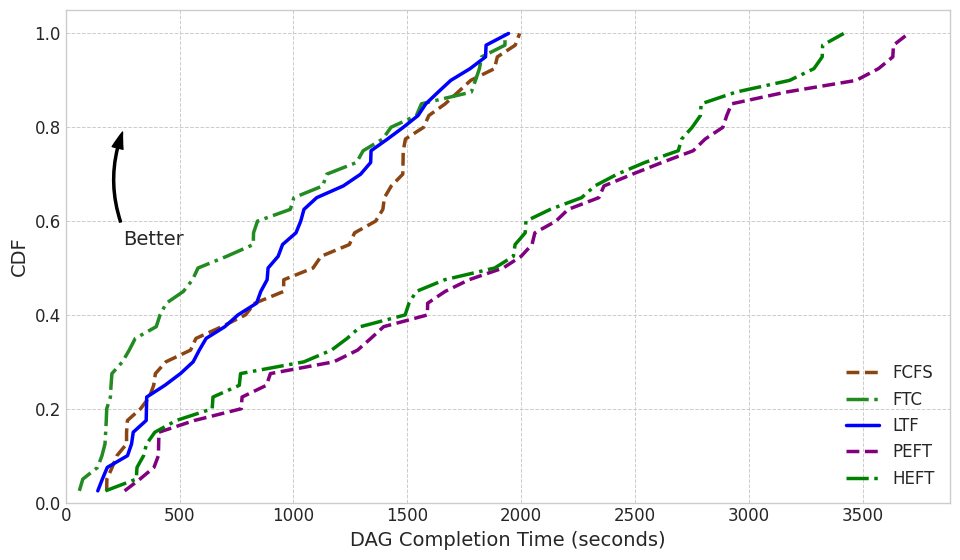

In [153]:
# Load the data using the corrected JCT calculation
completion_data = load_job_completion_times(DATA_DIR, ALGORITHMS_TO_PLOT)

# Generate, display, and save the plot
if completion_data:
    plot_cdf(completion_data, ALGORITHM_STYLES, OUTPUT_PDF_FILE)
else:
    print("\nSkipping plot generation due to lack of data.")

##### p95 response time

In [196]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [197]:
# --- 1. Configuration ---
# 数据目录：指向你的 "continuous arrival mode" 实验数据
DATA_DIR = '../data/exp2 scheduling algorithm/continuous arrival mode'
# 输出PDF文件的名称
OUTPUT_PDF_FILE = 'p95_response_time_cdf.pdf'

# 你可以修改这个列表来选择要绘制的算法
ALGORITHMS_TO_PLOT = ['fcfs', 'ftc', 'ltf', 'heft', 'peft'] 

# 用于计算P95响应时间序列的时间窗口大小（秒）
# 例如，120秒代表每2分钟计算一次P95值
WINDOW_SIZE_SEC = 120

# 为绘图定义显示名称、颜色和线条样式
ALGORITHM_STYLES = {
    'fcfs': ('FCFS', 'saddlebrown', '--'),
    'ftc': ('WestWorld (FTC)', '#1f77b4', '-'), 
    'ltf': ('WestWorld (LTF)', '#ff7f0e', '-'), 
    'heft': ('HEFT', '#2ca02c', '-.'),      
    'peft': ('PEFT', '#d62728', ':'),      
    'sjf': ('SJF', '#9467bd', (0, (3, 5, 1, 5))),
}

In [198]:
# --- 2. Data Loading and Processing ---

def load_p95_response_times(base_dir, algorithms_to_load, window_size):
    """
    加载数据，通过时间分箱计算P95响应时间序列。
    
    Returns:
        dict: {'algo_name': [p95_window1, p95_window2, ...]}
    """
    print(f"Searching for data in: {os.path.abspath(base_dir)}")
    p95_data = {}

    if not os.path.exists(base_dir):
        print(f"❌ Error: Data directory not found at '{base_dir}'")
        return p95_data

    if not algorithms_to_load:
        algorithms_to_load = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for algo_name in algorithms_to_load:
        # 假设每个算法目录下只有一个实验结果子目录（按seed或时间戳命名）
        algo_path = os.path.join(base_dir, algo_name)
        if not os.path.isdir(algo_path):
            continue
            
        task_file = os.path.join(algo_path, 'task_exec_time.csv')
        
        print(f"\nProcessing algorithm: {algo_name}")
        if os.path.exists(task_file):
            try:
                df = pd.read_csv(task_file)
                
                required_cols = ['run_id', 'arrival_time', 'finish_exec_time', 'response_time']
                if not all(col in df.columns for col in required_cols):
                    print(f"  - ❌ Error: File {task_file} is missing required columns. Skipping.")
                    continue
                
                # 计算每个DAG的完成时间和响应时间
                dag_runs = df.groupby('run_id').agg(
                    dag_finish_time=('finish_exec_time', 'max'),
                    dag_response_time=('response_time', 'max')
                ).reset_index()
                
                # 确定实验的相对开始时间
                exp_start_time = df['arrival_time'].min()
                dag_runs['relative_finish'] = dag_runs['dag_finish_time'] - exp_start_time
                
                # 创建时间分箱
                max_time = dag_runs['relative_finish'].max()
                time_bins = np.arange(0, max_time + window_size, window_size)
                
                # 按完成时间对DAG进行分箱
                dag_runs['finish_bin'] = pd.cut(dag_runs['relative_finish'], bins=time_bins, right=False)
                
                # 计算每个时间窗口内的P95响应时间
                p95_series = dag_runs.groupby('finish_bin')['dag_response_time'].quantile(0.95)
                
                # 过滤掉没有数据的窗口 (NaN)
                valid_p95_values = p95_series.dropna().tolist()
                
                if valid_p95_values:
                    p95_data[algo_name] = valid_p95_values
                    print(f"  - ✅ Calculated {len(valid_p95_values)} P95 values over {window_size}s windows.")
                else:
                    print(f"  - ⚠️ Warning: No valid P95 values found for {algo_name}.")

            except Exception as e:
                print(f"  - ❌ Error processing {task_file}: {e}")
        else:
            print(f"  - ⚠️ Warning: 'task_exec_time.csv' not found in {algo_path}. Skipping.")
            
    return p95_data

In [199]:
# --- 3. Plotting Function ---
def plot_p95_cdf(data, styles, output_filename):
    """
    绘制P95响应时间序列的CDF图。
    """
    if not data:
        print("No data available to plot.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    for algo_name, p95_values in data.items():
        display_name, color, linestyle = styles.get(algo_name, (algo_name, None, '-'))
        
        sorted_p95 = np.sort(p95_values)
        cdf = np.arange(1, len(sorted_p95) + 1) / len(sorted_p95)
        
        ax.plot(sorted_p95, cdf, label=display_name, color=color, linestyle=linestyle, linewidth=2.5)

    # 美化图表
    ax.set_title('CDF of P95 Response Time under Continuous Load (85%)', fontsize=16, fontweight='bold')
    ax.set_xlabel('P95 Response Time (seconds)', fontsize=14)
    ax.set_ylabel('CDF', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0, top=1.05)

    # 创建图例
    legend_handles = [Line2D([0], [0], color=s[1], lw=2.5, linestyle=s[2], label=s[0]) 
                      for k, s in styles.items() if k in data]
    ax.legend(handles=legend_handles, fontsize=12, loc='lower right')

    # 添加 "Better" 标注
    arrow_x_pos = np.percentile(np.concatenate(list(data.values())), 10) if data else 1
    ax.annotate('Better', xy=(arrow_x_pos, 0.8), 
                xytext=(arrow_x_pos * 1.5, 0.55),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8, connectionstyle="arc3,rad=-0.2"),
                fontsize=14, ha='center')

    fig.tight_layout()

    # 保存图表
    try:
        fig.savefig(output_filename, format='pdf', bbox_inches='tight')
        print(f"\n✅ Plot successfully saved to: {os.path.abspath(output_filename)}")
    except Exception as e:
        print(f"\n❌ Error saving plot to PDF: {e}")

    plt.show()

Searching for data in: /root/workspace/d23oa7cp420c73acue30/AgentOS/src/experiment/data/exp2 scheduling algorithm/continuous arrival mode

Processing algorithm: fcfs
  - ✅ Calculated 14 P95 values over 120s windows.

Processing algorithm: ftc
  - ✅ Calculated 13 P95 values over 120s windows.

Processing algorithm: ltf
  - ✅ Calculated 15 P95 values over 120s windows.

Processing algorithm: heft
  - ✅ Calculated 13 P95 values over 120s windows.

Processing algorithm: peft
  - ✅ Calculated 10 P95 values over 120s windows.

✅ Plot successfully saved to: /root/workspace/d23oa7cp420c73acue30/AgentOS/src/experiment/utils/p95_response_time_cdf.pdf


/tmp/ipykernel_709/445564289.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p95_series = dag_runs.groupby('finish_bin')['dag_response_time'].quantile(0.95)
/tmp/ipykernel_709/445564289.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p95_series = dag_runs.groupby('finish_bin')['dag_response_time'].quantile(0.95)
/tmp/ipykernel_709/445564289.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p95_series = dag_r

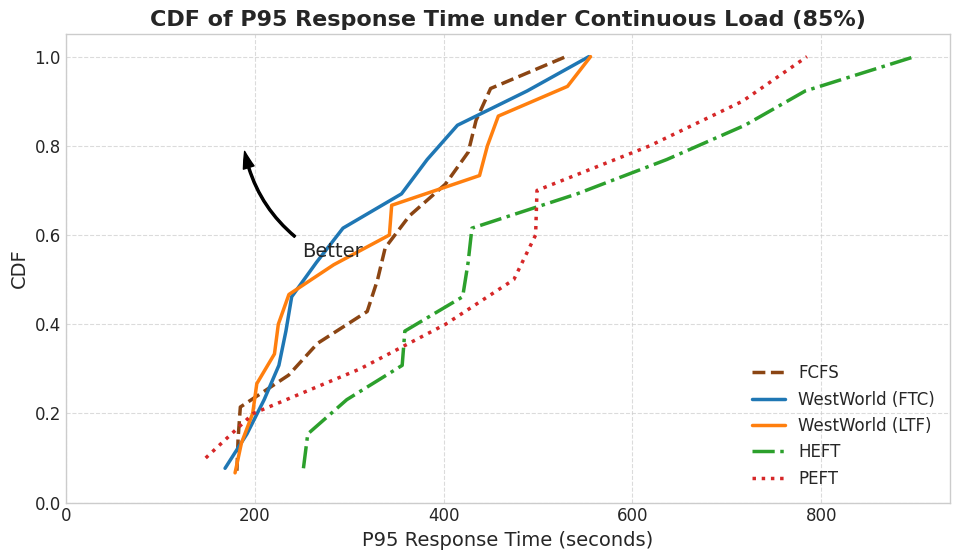

In [200]:
# 1. 加载并计算P95响应时间序列
p95_response_data = load_p95_response_times(DATA_DIR, ALGORITHMS_TO_PLOT, WINDOW_SIZE_SEC)

# 2. 绘制CDF图
if p95_response_data:
    plot_p95_cdf(p95_response_data, ALGORITHM_STYLES, OUTPUT_PDF_FILE)
else:
    print("\nNo data was loaded. Skipping plotting.")


#### Continuous arrival